<a href="https://colab.research.google.com/github/robson-rsp/datascience/blob/main/timeseries/hourly_energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Contexto

##Previsão de consumo de energia elétrica.

O conjunto de dados desse kernel corresponde ao consumo de energia elétrica feito por uma concessionária de energia da cidade ...
Esse registro foi feito de hora em hora durante mais de quinze anos. A tarefa é prever o consumo de energia elétrica da cidade para o ano seguinte. A unidade de medida é megawatt(MW).

Fonte: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

#Imports iniciais

In [ ]:
%pip install ipython-autotime --upgrade
%pip install matplotlib       --upgrade
%pip install scikit-learn     --upgrade
%pip install seaborn          --upgrade

In [49]:
from google.colab import drive, files
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
drive.mount('/content/drive')

%load_ext autotime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.1 s (started: 2023-03-12 17:11:58 +00:00)


In [149]:
dataset = pd.read_csv('/content/drive/MyDrive/datasets/hourly-energy-consumption/PJME_hourly.csv', index_col='Datetime', parse_dates=True)
dataset = dataset.sort_index()
dataset = dataset.drop(dataset.tail(1).index, axis=0) # detalhe para ajustar os dias na hora de fazer as previsões.

time: 316 ms (started: 2023-03-12 18:24:19 +00:00)


#EDA

In [ ]:
dataset

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 19:00:00,45641.0
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0


time: 15 ms (started: 2023-03-11 23:36:42 +00:00)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145365 entries, 2002-01-01 01:00:00 to 2018-08-02 23:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145365 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
time: 23.9 ms (started: 2023-03-11 17:16:58 +00:00)


In [37]:
dataset['PJME_MW'].describe()

count    145365.000000
mean      32080.199402
std        6464.028228
min       14544.000000
25%       27573.000000
50%       31421.000000
75%       35650.000000
max       62009.000000
Name: PJME_MW, dtype: float64

time: 26.2 ms (started: 2023-03-12 17:10:09 +00:00)


**Conclusão:** Os registros começaram em 2002 a foram até 2018. O conjunto possui apenas uma coluna contendo o consumo. É o suficiente para modelos tradicionais de séries temporais, como ARIMA, mas insuficiente para modelos de aprendizado de máquina. Como pretendo usar estes, tenho que extrair informações a partir do que já tenho e criar novos atributos. Mas, principalmente criar a label(lag features).

##Data visualization


In [55]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

time: 5.46 ms (started: 2023-03-12 17:12:51 +00:00)


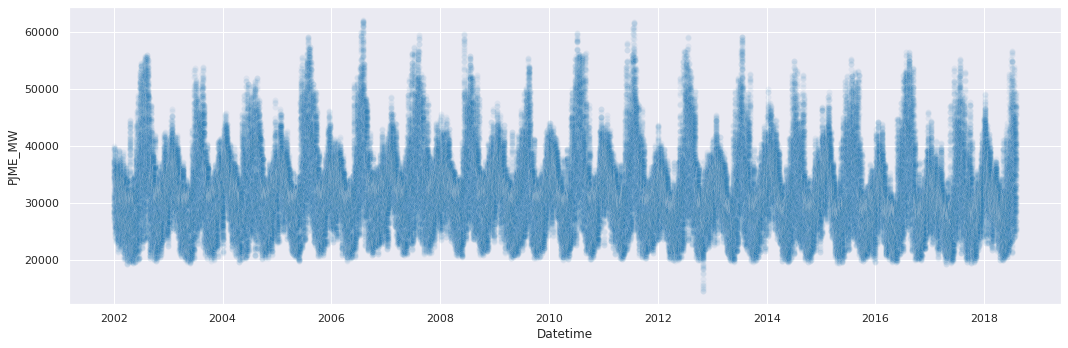

time: 4.57 s (started: 2023-03-12 18:14:28 +00:00)


In [130]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.scatterplot(data=dataset, x=dataset.index, y=dataset['PJME_MW'], color=colors[0], alpha=0.07)
plt.tight_layout()
plt.show()

**Conclusão:** É visível a sazonalidade no decorrer dos anos, mas para ver de forma mais clara vou isolar um ano apenas.

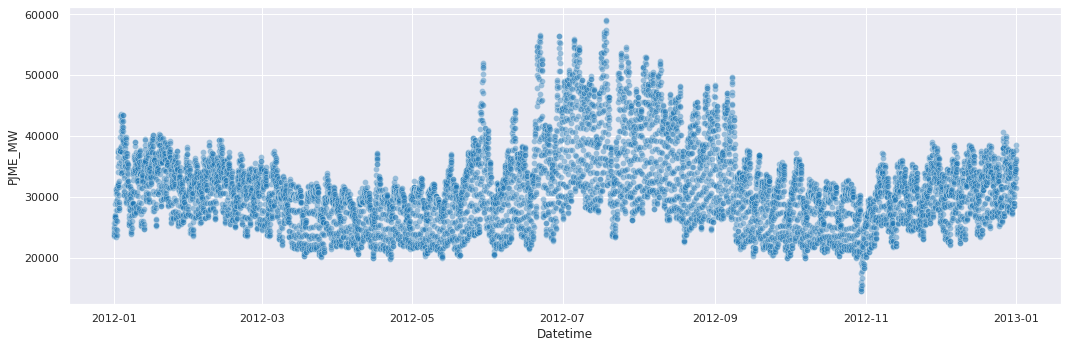

time: 1.55 s (started: 2023-03-12 18:15:41 +00:00)


In [135]:
mask = (dataset.index > '2012-01-01') & (dataset.index < '2013-01-01')
year = dataset[mask]

sns.set(rc={'figure.figsize':(15, 5)})
sns.scatterplot(x=year.index, y=year['PJME_MW'], color=colors[0], alpha=0.4)
plt.tight_layout()
plt.show()

**Conclusão:** Aqui, é possível ver em quais meses o consumo é menor e maior. Provavelmente tem relação com as estações do ano. Este é um atributo que eu posso adicionar ao conjunto de dados. Além disso, podemos  ver claramente a presença de outliers no final do ano de 2012. Quem sabe no mês de novembro, onde há registros de consumo bem abaixo do que normalmente é esperado, 20_000MW.

Vou 'aproximar' ainda mais a visualização e escolher um mês qualquer para analisar o consumo. Quem sabe há um padrão relacionado aos dias úteis e finais de semana.

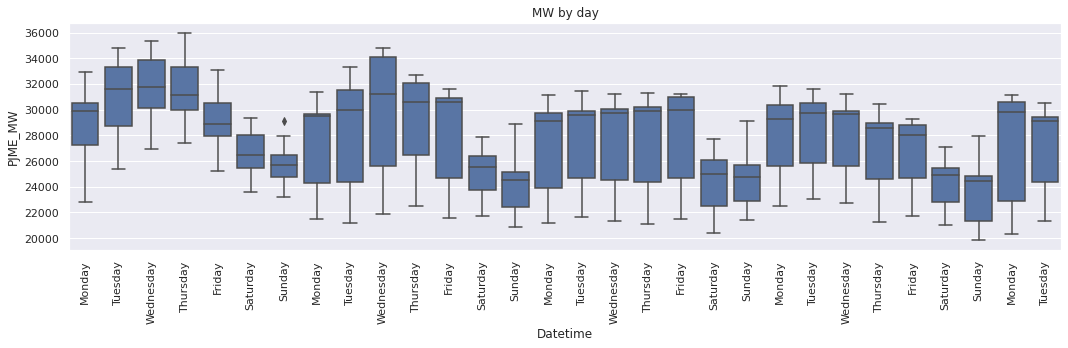

time: 1.55 s (started: 2023-03-11 12:59:13 +00:00)


In [ ]:
# obtem os dias da semana do mês de abril de 2013
start_date = datetime.date(2013, 4, 1)
end_date = datetime.date(2013, 4, 30)
date_range = pd.date_range(start_date, end_date)
days_of_week = date_range.day_name()
days_of_week

mask = (dataset.index > '2013-04-01') & (dataset.index < '2013-05-01')
month = dataset[mask]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('MW by day')
sns.boxplot(x=month.index.day, y=month['PJME_MW'], color=colors[0], ax=ax)
ax.set_xticklabels(days_of_week, rotation=90)
plt.tight_layout()
plt.show()

**Conclusão:** Os finais de semana são os que possuem menor consumo de energia. Talvez seja porque as pessoas não estão trabalhando, e as indústrias estão fechadas. Dos dias úteis, terça-feira, quarta-feira e quinta-feira são os dias onde há maior consumo.

Por último, vou visualizar um único dia.

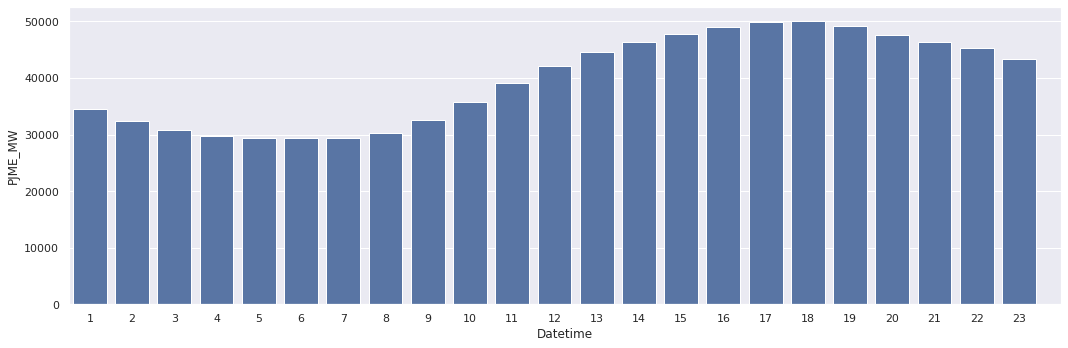

time: 2.23 s (started: 2023-03-11 13:49:40 +00:00)


In [ ]:
mask = (dataset.index > '2012-07-04') & (dataset.index < '2012-07-05')
day = dataset[mask]

sns.set(rc={'figure.figsize':(15, 5)})
sns.barplot(x=day.index.hour, y=day['PJME_MW'], color=colors[0])
plt.xticks(range(24))
plt.tight_layout()
plt.show()

**Conclusão:** Durante a madruga é onde há o menor consumo de energia elétrica. O período do dia onde há maior gasto é o do meio da tarde, início da noite.

#Train/Test split

In [138]:
from sklearn.model_selection import TimeSeriesSplit

time: 757 µs (started: 2023-03-12 18:16:44 +00:00)


Vou definir um conjunto de teste com tamanho equivalente a um pouco mais de 20% do conjunto completo. Isso é o equivalenete a quatro anos.

In [139]:
hours = 24
days  = 365
year  = 4

tss = TimeSeriesSplit(n_splits=2, test_size=(hours * days * year), gap=hours)
folds = tss.split(dataset)

next(folds)
train_indexes, test_indexes = next(folds) # só o último fold me interessa pois é o maior

train_set = dataset.iloc[train_indexes]
test_set  = dataset.iloc[test_indexes]

# a única alteração que farei nestes conjuntos será renomear suas colunas para serems usados no Prophet
train_set_prophet = train_set.copy()
test_set_prophet  = test_set.copy()

time: 11.9 ms (started: 2023-03-12 18:16:44 +00:00)


Abaixo, uma breve visualização do conjunto de treinamento e teste.

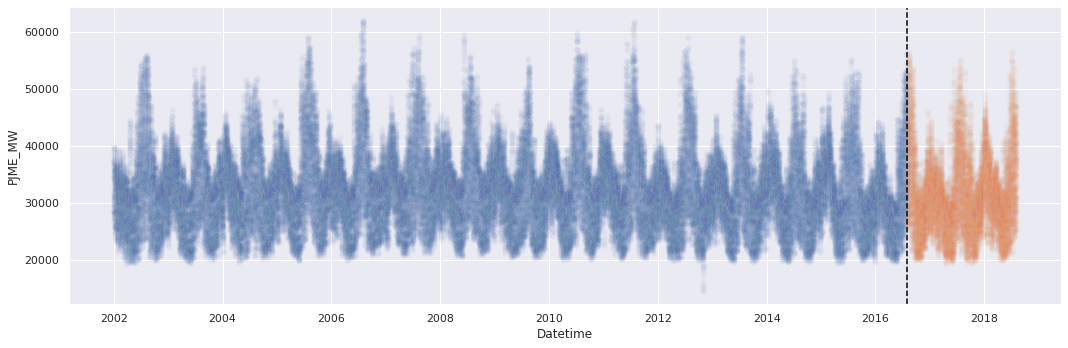

time: 1.42 s (started: 2023-03-12 18:26:04 +00:00)


In [153]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

axs.axvline(test_set.index.min(), color='black', ls='--')
sns.scatterplot(x=train_set.index, y=train_set['PJME_MW'], ax=axs, alpha=0.04)
sns.scatterplot(x=test_set.index, y=test_set['PJME_MW'], ax=axs, alpha=0.04)
  
plt.tight_layout()
plt.show()

#Feature engineering

In [61]:
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline

time: 1.32 ms (started: 2023-03-12 17:15:12 +00:00)


**Etapa ##: Renomeação de atributos:** Pequeno ajuste para o conjunto de dados se adequar ao modelo Prophet.

In [62]:
train_set_prophet['ds'] = train_set_prophet.index
train_set_prophet.rename(columns={'PJME_MW': 'y'}, inplace=True)

test_set_prophet['ds'] = test_set_prophet.index
test_set_prophet.rename(columns={'PJME_MW': 'y'}, inplace=True)

time: 6.22 ms (started: 2023-03-12 17:15:14 +00:00)


**Etapa ##: Criação de atributos:** Vou criar alguns atributos a partir das datas de registro de consumo de energia elétrica.

In [63]:
class FeaturesFromIndex(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)


  def get_feature_names_out(self):
    pass

  def transform(self, X, y=None):
    X = X.copy()
    X['hour']       = X.index.hour
    X['dayofweek']  = X.index.day_of_week
    X['month']      = X.index.month
    X['year']       = X.index.year
    return X



pipeline_create_features = Pipeline(steps=[('features_from_index', FeaturesFromIndex())])

time: 3.38 ms (started: 2023-03-12 17:15:17 +00:00)


**Etapa ##: Criação da lag feature:** A tarefa aqui é o modelo fazer previsões de consumo para o ano seguinte. Por isso vou criar um atributo onde cada registro terá o correspondente de consumo de um ano atrás.

In [64]:
class OneYearLag(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def transform(self, X, y=None):
    X = X.copy()
    label_map = X['PJME_MW'].to_dict()

    # tem que ser 364 dias no passado para o mapeamento ficar preciso com o mesmo dia no ano anterior
    X['day_before'] = (X.index - pd.Timedelta(value=364, unit='day')).map(label_map)
    return X.dropna()



pipeline_one_year_lag = Pipeline(steps=[('one_year_lag', OneYearLag())])

time: 11.3 ms (started: 2023-03-12 17:15:18 +00:00)


**Etapa final: Pipeline completo:**

In [65]:
pipeline_full = Pipeline(steps=[('pipeline_create_features', pipeline_create_features),
                                ('pipeline_one_year_lag', pipeline_one_year_lag), ])

train_set = pipeline_full.fit_transform(train_set)
test_set  = pipeline_full.transform(test_set)

y_train = train_set['PJME_MW']
X_train = train_set.drop('PJME_MW', axis=1)

y_test = test_set['PJME_MW']
X_test = test_set.drop('PJME_MW', axis=1)

time: 1.8 s (started: 2023-03-12 17:15:20 +00:00)


#Models training

In [11]:
%pip install git+https://github.com/scikit-optimize/scikit-optimize.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
time: 34 s (started: 2023-03-12 14:06:20 +00:00)


In [66]:
from sklearn.base     import clone
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics  import mean_squared_error
from skopt            import BayesSearchCV
from xgboost          import XGBRegressor
from prophet          import Prophet

import lightgbm as lgb
import numpy as np

time: 1.73 ms (started: 2023-03-12 17:15:24 +00:00)


Vou testar dois modelos baseados em árvores e o modelo do Facebook, Prophet. Farei ajuste de hiper-parâmetros nos dois mais promissores.

##Custom cross validation

Criei duas funções de validação cruzada, uma será usada no conjunto de dados adaptado para modelos de aprendizado de máquina, o outro será usado no modelo do Facebook, Prophet.

**Obs.** Reduzi o tamanho do conjunto de teste para 'year=2' porque o dataset considerado dentro de cada função não possui dados suficientes.

In [74]:
def custom_cross_val(model, dataset, pipeline):
  hours = 24
  days  = 365
  year  = 2
  
  scores = list()
  tss = TimeSeriesSplit(n_splits=5, test_size=(hours * days * year), gap=hours)
  for train_indexes, val_indexes in tss.split(dataset):
    train_set       = dataset.iloc[train_indexes]
    validation_set  = dataset.iloc[val_indexes]

    train_set       = pipeline_full.fit_transform(train_set)
    validation_set  = pipeline_full.transform(validation_set)

    y_train = train_set['PJME_MW']
    X_train = train_set.drop('PJME_MW', axis=1)

    y_val = validation_set['PJME_MW']
    X_val = validation_set.drop('PJME_MW', axis=1)

    model_clone = clone(model)
    model_clone.fit(X_train, y_train)
    y_pred = model_clone.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)
  return scores

time: 3.14 ms (started: 2023-03-12 17:17:13 +00:00)


In [78]:
def prophet_cross_val(dataset):
  hours = 24
  days  = 365
  year  = 2
  
  scores = list()
  tss = TimeSeriesSplit(n_splits=5, test_size=(hours * days * year), gap=hours)
  for train_indexes, val_indexes in tss.split(dataset):
    train_set       = dataset.iloc[train_indexes]
    validation_set  = dataset.iloc[val_indexes]

    pro = Prophet(interval_width=0.95)
    pro.fit(train_set)

    y_pred = pro.predict(validation_set)
    score = np.sqrt(mean_squared_error(validation_set['y'], y_pred['yhat']))
    scores.append(score)
  return scores

time: 2.17 ms (started: 2023-03-12 17:20:44 +00:00)


Abaixo, a visualização dos folds que serão usados na validação cruzada.

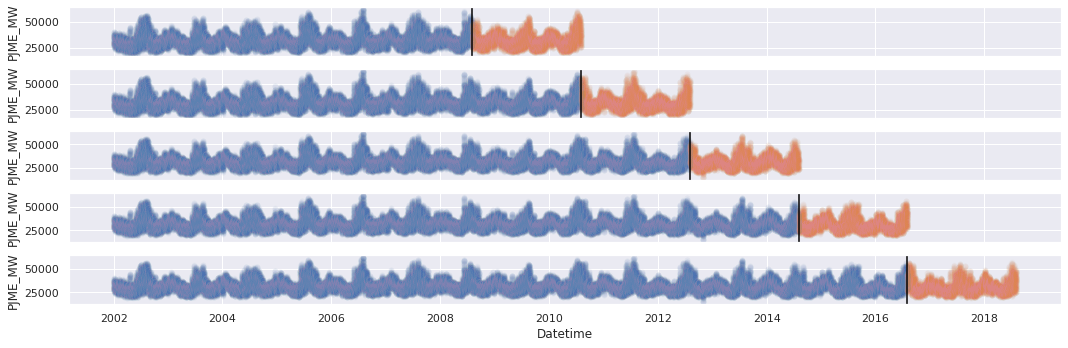

time: 7.67 s (started: 2023-03-12 18:22:40 +00:00)


In [148]:
hours = 24
days  = 365
year  = 2
tss = TimeSeriesSplit(n_splits=5, test_size=(hours * days * year), gap=hours)

fig, axs = plt.subplots(5, 1, figsize=(15, 5), sharex=True)
axs = axs.ravel()
index = 0

for train_indexes, test_indexes in tss.split(dataset):
  train_set = dataset.iloc[train_indexes]
  test_set  = dataset.iloc[test_indexes]
  axs[index].axvline(test_set.index.min(), color='black')
  sns.scatterplot(x=train_set.index, y=train_set['PJME_MW'], ax=axs[index], alpha=0.03)
  sns.scatterplot(x=test_set.index, y=test_set['PJME_MW'], ax=axs[index], alpha=0.03)
  index += 1
  
plt.tight_layout()
plt.show()

##LGBMRegressor

In [75]:
scores = custom_cross_val(lgb.LGBMRegressor(), train_set, pipeline_full)
print(f'Mean RMSE: {np.mean(scores):.2f}')
print(f'Std Dev:   {np.std(scores):.2f}')

Mean RMSE: 3869.24
Std Dev:   203.02
time: 14.2 s (started: 2023-03-12 17:17:18 +00:00)


##XGBRegressor

In [76]:
scores = custom_cross_val(XGBRegressor(), train_set, pipeline_full)
print(f'Mean RMSE: {np.mean(scores):.2f}')
print(f'Std Dev:   {np.std(scores):.2f}')

Mean RMSE: 3950.68
Std Dev:   124.12
time: 23.3 s (started: 2023-03-12 17:19:36 +00:00)


##Prophet

In [79]:
scores = prophet_cross_val(train_set_prophet)
print(f'Mean RMSE: {np.mean(scores):.2f}')
print(f'Std Dev:   {np.std(scores):.2f}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpr76bz7cm/4_1t0m8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr76bz7cm/92_6bo82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61568', 'data', 'file=/tmp/tmpr76bz7cm/4_1t0m8r.json', 'init=/tmp/tmpr76bz7cm/92_6bo82.json', 'output', 'file=/tmp/tmpr76bz7cm/prophet_model213y46ym/prophet_model-20230312172052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr76bz7cm/hl0o5_5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr76bz7cm/8s366q5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Mean RMSE: 7172.80
Std Dev:   6081.46
time: 7min 51s (started: 2023-03-12 17:20:49 +00:00)


##Best models hyperparameter optimization

Os modelos com melhor desempenho, são:

1.   XGBoostRegressor
   *   Mean RMSE: 3783.48
   *   Std Dev:   1831.87

2.   LGBMRegressor
   *   Mean RMSE: 3822.60
   *   Std Dev:    1824.12


###XGBRegressor

In [ ]:
params = {'learning_rate': np.arange(0.01, 0.9, 0.1),
          'gamma': np.arange(0.01, 0.9, 0.1),
          'booster': ['gbtree', 'dart'],
          'max_depth': np.arange(6, 20, 2),
          'max_leaves': np.arange(6, 40, 2),
          'min_child_weight': np.arange(0, 20, 2),}

bscv = BayesSearchCV(XGBRegressor(), params, n_iter=30, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=False)
bscv.fit(X_train, y_train)

xgb_best = bscv.best_estimator_
xgb_best

/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.9/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=32,
             min_child_weight=18, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

time: 1h 17min 31s (started: 2023-03-12 01:49:25 +00:00)


In [ ]:
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_train)
print(f'Mean RMSE: {np.sqrt(mean_squared_error(y_train, y_pred)):.2f}')

Mean RMSE: 2669.81
time: 23.5 s (started: 2023-03-12 13:28:36 +00:00)


In [ ]:
y_pred = xgb_best.predict(X_test)
print(f'Mean RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')

Mean RMSE: 1474.50
time: 38.8 ms (started: 2023-03-12 13:29:00 +00:00)


Abaixo, uma pequena visuzaliação das previsões juntamente com as registros reais.

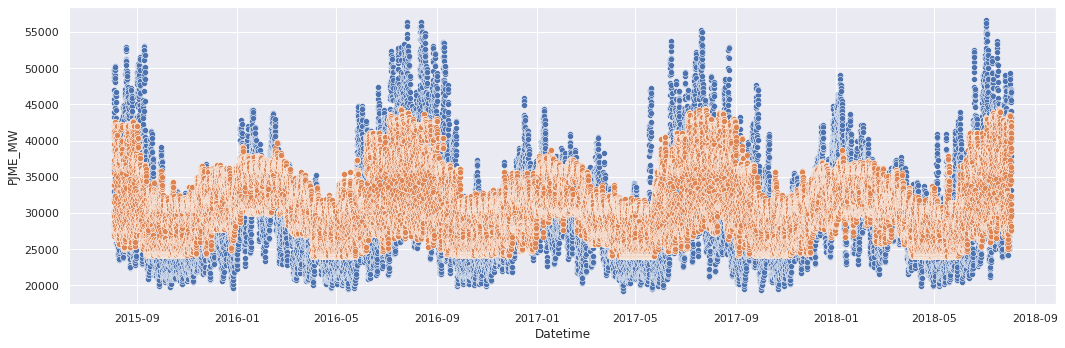

time: 3.05 s (started: 2023-03-12 17:53:45 +00:00)


In [ ]:
test_set_ = test_set.copy()
test_set_['predictions'] = y_pred

sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.scatterplot(x=test_set_.index, y=test_set_['PJME_MW'])
sns.scatterplot(x=test_set_.index, y=test_set_['predictions'], ax=ax)
plt.tight_layout()
plt.show()

###LGBMRegressor

In [80]:
params = {'num_iterations': np.arange(100, 600, 100),
          'learning_rate': np.arange(0.01, 0.3, 0.01),
          'max_leaf_nodes': np.arange(10, 60, 10),
          'max_depth': np.arange(6, 20, 2),}

bscv = BayesSearchCV(lgb.LGBMRegressor(), params, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=False)
bscv.fit(X_train, y_train, verbose=False)

lgb_best = bscv.best_estimator_
lgb_best

LGBMRegressor(learning_rate=0.01, max_depth=8, max_leaf_nodes=40,
              num_iterations=200)

time: 9min 25s (started: 2023-03-12 17:29:29 +00:00)


In [102]:
lgb_best.fit(X_train, y_train)
y_pred = lgb_best.predict(X_train)
print(f'Mean RMSE: {np.sqrt(mean_squared_error(y_train, y_pred)):.2f}')

Mean RMSE: 3531.31
time: 4.4 s (started: 2023-03-12 17:46:55 +00:00)


In [103]:
y_pred = lgb_best.predict(X_test)
print(f'Mean RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')

Mean RMSE: 3937.51
time: 178 ms (started: 2023-03-12 17:47:01 +00:00)


Abaixo, uma pequena visuzaliação das previsões juntamente com as registros reais.

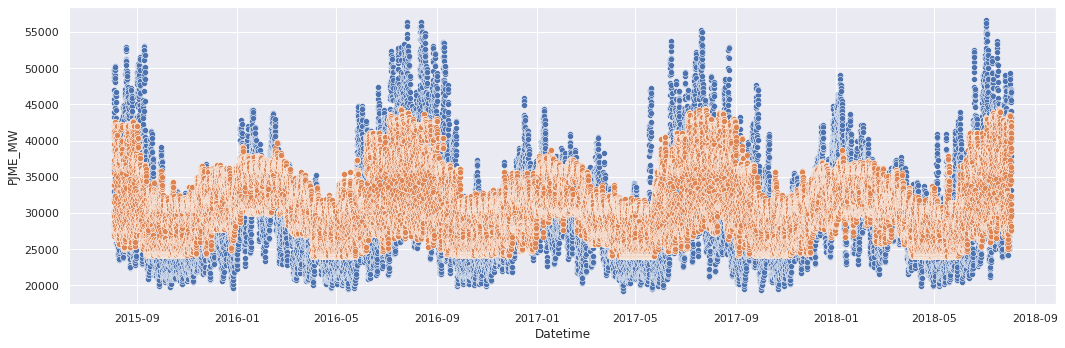

time: 3.05 s (started: 2023-03-12 17:53:45 +00:00)


In [108]:
test_set_ = test_set.copy()
test_set_['predictions'] = y_pred

sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.scatterplot(x=test_set_.index, y=test_set_['PJME_MW'])
sns.scatterplot(x=test_set_.index, y=test_set_['predictions'], ax=ax)
plt.tight_layout()
plt.show()